# Solar System Propagation
Copyright (c) 2010-2022, Delft University of Technology. All rights reserved. This file is part of the Tudat. Redistribution and use in source and binary forms, with or without modification, are permitted exclusively under the terms of the Modified BSD license. You should have received a copy of the license with this file. If not, please or visit: http://tudat.tudelft.nl/LICENSE.

## Context
This example demonstrates a multi-body propagation of simplified inner solar system model.
Multi-body propagations become necessary when one or more propagated bodies cannot be treated as quasi-massless.
Through their non-negligible mass, the bodies mutually exert accelerations on each other and thereby affecting each others' future states.

In order to consistently simulate the evolution of such a system, the equations of motion of all massive bodies have to be propagated concurrently in a multi-body propagation.

The example showcases the versatility with which the propagation_setup module allows for advanced multi-body acceleration models and propagators.
Via the selected_acceleration_per_body argument of the `propagation_setup.create_acceleration_models()` function, acceleration model settings can be defined for an arbitrary amount of bodies in the system.

The central_bodies argument gives the option specify the centre of propagation for each propagated body individually.
In this script, this feature is used to implement a hierarchical propagation scheme.

## Import statements
The required import statements are made here, at the very beginning.

Some standard modules are first loaded. These are `numpy` and `matplotlib.pyplot`.

Then, the different modules of `tudatpy` that will be used are imported.

In [1]:
# Load standard modules
import numpy as np
from matplotlib import pyplot as plt

# Load tudatpy modules
from tudatpy.kernel.interface import spice
from tudatpy.kernel import numerical_simulation
from tudatpy.kernel.numerical_simulation import environment_setup, propagation_setup, propagation
from tudatpy.kernel import constants
from tudatpy.util import result2array

## Configuration
NAIF's `SPICE` kernels are first loaded, so that the position of various bodies such as the Earth can be make known to `tudatpy`.

Then, the start and end simulation epochs are setups. In this case, the start epoch is set to `1e7`, corresponding to 10 million seconds ($\approx$ 115.74 days) after the 1st of January 2000. The end epoch is set 5 years later.

The times should always be specified in seconds since J2000.
Please refer to the API documentation of the `time_conversion module` [here](https://tudatpy.readthedocs.io/en/latest/time_conversion.html) for more information on this.

In [2]:
# Load spice kernels
spice.load_standard_kernels()

# Set simulation start and end epochs (total simulation time of 5 years)
simulation_start_epoch = 1.0e7
simulation_end_epoch = 1.0e7 + 5.0 * constants.JULIAN_YEAR

## Environment setup
Let’s create the environment for our simulation. This setup covers the creation of (celestial) bodies, vehicle(s), and environment interfaces.

### Create the bodies
Bodies can be created by making a list of strings with the bodies that is to be included in the simulation.

The default body settings (such as atmosphere, body shape, rotation model) are taken from `SPICE`.

These settings can be adjusted. Please refere to the [Available Environment Models](https://tudat-space.readthedocs.io/en/latest/_src_user_guide/state_propagation/environment_setup/create_models/available.html#available-environment-models) in the user guide for more details.

Finally, the system of bodies is created using the settings. This system of bodies is stored into the variable `body_system`.

In [3]:
# Define bodies in simulation
bodies_to_create = [
    "Moon",
    "Earth",
    "Mars",
    "Venus",
    "Mercury",
    "Sun"
]
bodies_to_propagate = bodies_to_create

# Create bodies in simulation.
body_settings = environment_setup.get_default_body_settings(bodies_to_create)
body_system = environment_setup.create_system_of_bodies(body_settings)

## Propagation setup
Now that the environment is created, the propagation setup is defined.

First, central bodies are defined separately for the barycentric and hierarchical propagations.

The central bodies are the bodies with respect to which the state of the respective propagated bodies is defined.

In [4]:
# Central bodies for barycentric propagation
central_bodies_barycentric = ["SSB"] * len(bodies_to_create)

# Central bodies for hierarchical parent body propagation
central_bodies_hierarchical = []
for body_name in bodies_to_create:
    if body_name == "Moon":
        central_bodies_hierarchical.append("Earth")
    elif body_name == "Sun":
        central_bodies_hierarchical.append("SSB")
    else:
        central_bodies_hierarchical.append("Sun")

### Create the acceleration model
The acceleration settings that act each body are first defined. These accelerations only consist in the gravitational effect of each other body modeled as a Point Mass.

These acceleration settings, taking the form of a dictionnary, are then converted to acceleration models both for the barycentric and the hierarchical propagation variant, using the respective central bodies.

In [5]:
# Define the accelerations acting on each body
acceleration_dict = {}
for body_i in bodies_to_create:
    current_accelerations = {}
    for body_j in bodies_to_create:
        if body_i != body_j:
            current_accelerations[body_j] = [
                propagation_setup.acceleration.point_mass_gravity()
            ]
    acceleration_dict[body_i] = current_accelerations
        
# Convert acceleration mappings into acceleration models for both propagation variants
for propagation_variant in ["barycentric", "hierarchical"]:
    central_bodies = central_bodies_barycentric if propagation_variant == "barycentric" else central_bodies_hierarchical

    acceleration_models = propagation_setup.create_acceleration_models(
        body_system=body_system,
        selected_acceleration_per_body=acceleration_dict,
        bodies_to_propagate=bodies_to_propagate,
        central_bodies=central_bodies
    )
    
    if propagation_variant == "barycentric":
        acceleration_models_barycentric = acceleration_models
    else:
        acceleration_models_hierarchical = acceleration_models

### Define the initial state
The initial state of each body now has to be defined.
These initial positions are taken directly from SPICE, and are different for both propagation variants, since the central bodies are different.

In [6]:
# Define the initial state of each body, taking them from SPICE
for propagation_variant in ["barycentric", "hierarchical"]:
    central_bodies = central_bodies_barycentric if propagation_variant == "barycentric" else central_bodies_hierarchical
    
    system_initial_state = propagation.get_initial_state_of_bodies(
        bodies_to_propagate=bodies_to_propagate,
        central_bodies=central_bodies,
        body_system=body_system,
        initial_time=simulation_start_epoch
    )
    
    if propagation_variant == "barycentric":
        system_initial_state_barycentric = system_initial_state
    else:
        system_initial_state_hierarchical = system_initial_state

### Create the propagator settings
The propagator settings are now defined.

First, a termination setting is setup so that the propagation stops after 5 simulated years.

Subsequently, the integrator settings are defined using a RK4 integrator with the fixed step size of 1 hour.

Then, the translational propagator settings are defined seperately for both system of central bodies.

In [7]:
# Create termination settings
termination_settings = propagation_setup.propagator.time_termination(simulation_end_epoch)

# Create numerical integrator settings
fixed_step_size = 3600.0
integrator_settings = propagation_setup.integrator.runge_kutta_4(fixed_step_size)

# Create propagation settings
for propagation_variant in ["barycentric", "hierarchical"]:
    
    if propagation_variant == "barycentric":
        propagator_settings_barycentric = propagation_setup.propagator.translational(
            central_bodies_barycentric,
            acceleration_models_barycentric,
            bodies_to_propagate,
            system_initial_state_barycentric,
            simulation_start_epoch,
            integrator_settings,
            termination_settings
        )
    else:
        propagator_settings_hierarchical = propagation_setup.propagator.translational(
            central_bodies_hierarchical,
            acceleration_models_hierarchical,
            bodies_to_propagate,
            system_initial_state_hierarchical,
            simulation_start_epoch,
            integrator_settings,
            termination_settings
        )

## Propagate the bodies
Each of the bodies can now be simulated.

This is done by calling the `create_dynamics_simulator()` function of the `numerical_simulation` module.
This function requires the `body_system` and the appropriate `propagator_settings_X` (with X being the propagation varian), that have all been defined earlier.

In the same step, the history of the propagated states over time, containing both the position and velocity history, is extracted.
This history takes the form of a dictionary. The keys are the simulated epochs, and the values are an array containing the states of all of the bodies one after another.

In [8]:
# Propagate the system of bodies and save the state history (all in one step)
for propagation_variant in ["barycentric", "hierarchical"]:
    
    if propagation_variant == "barycentric":
        results_barycentric = numerical_simulation.create_dynamics_simulator(
            body_system, propagator_settings_barycentric).state_history
    else:
        results_hierarchical = numerical_simulation.create_dynamics_simulator(
            body_system, propagator_settings_hierarchical).state_history

## Post-process the propagation results
The results of the propagation are then processed to a more user-friendly form.

### Plot the barycentric system evolution in 3D
Let's first plot the trajectory of each of the bodies in 3 dimensions, with respect to the Solar System Barycenter.

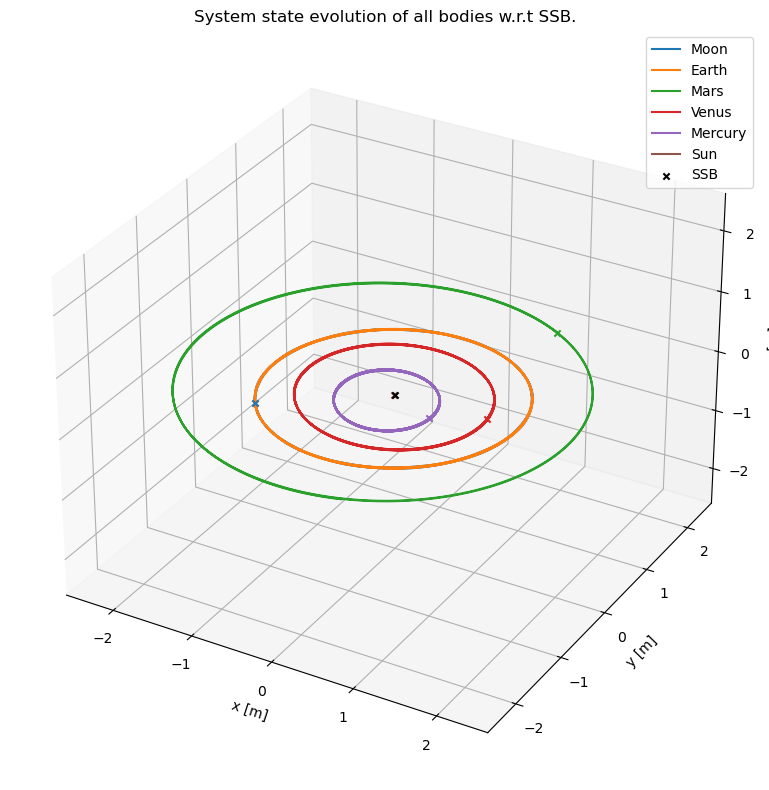

In [9]:
# Convert the state dictionnary to a multi-dimensional array
barycentric_system_state_array = result2array(results_barycentric)

fig1 = plt.figure(figsize=(8, 8))
ax1 = fig1.add_subplot(111, projection='3d')
ax1.set_title(f'System state evolution of all bodies w.r.t SSB.')

for i, body in enumerate(bodies_to_propagate):
    # Plot the 3D trajectory of each body
    ax1.plot(barycentric_system_state_array[:, 6 * i + 1], barycentric_system_state_array[:, 6 * i + 2],
             barycentric_system_state_array[:, 6 * i + 3],
             label=body)
    # Plot the initial position of each body
    ax1.scatter(barycentric_system_state_array[0, 6 * i + 1], barycentric_system_state_array[0, 6 * i + 2],
                barycentric_system_state_array[0, 6 * i + 3],
                marker='x')

# Add the position of the central body: the Solar System Barycenter
ax1.scatter(0, 0, 0, marker='x', label="SSB", color='black')

# Add a legend, labels, and use a tight layout to save space
ax1.legend()
ax1.set_xlabel('x [m]')
ax1.set_xlim([-2.5E11, 2.5E11])
ax1.set_ylabel('y [m]')
ax1.set_ylim([-2.5E11, 2.5E11])
ax1.set_zlabel('z [m]')
ax1.set_zlim([-2.5E11, 2.5E11])
plt.tight_layout()

### Plot the hierarchical system evolution in 3D
Finally, let's plot the bodies that directly orbit their distinct central bodies, as from the hierarchical system.

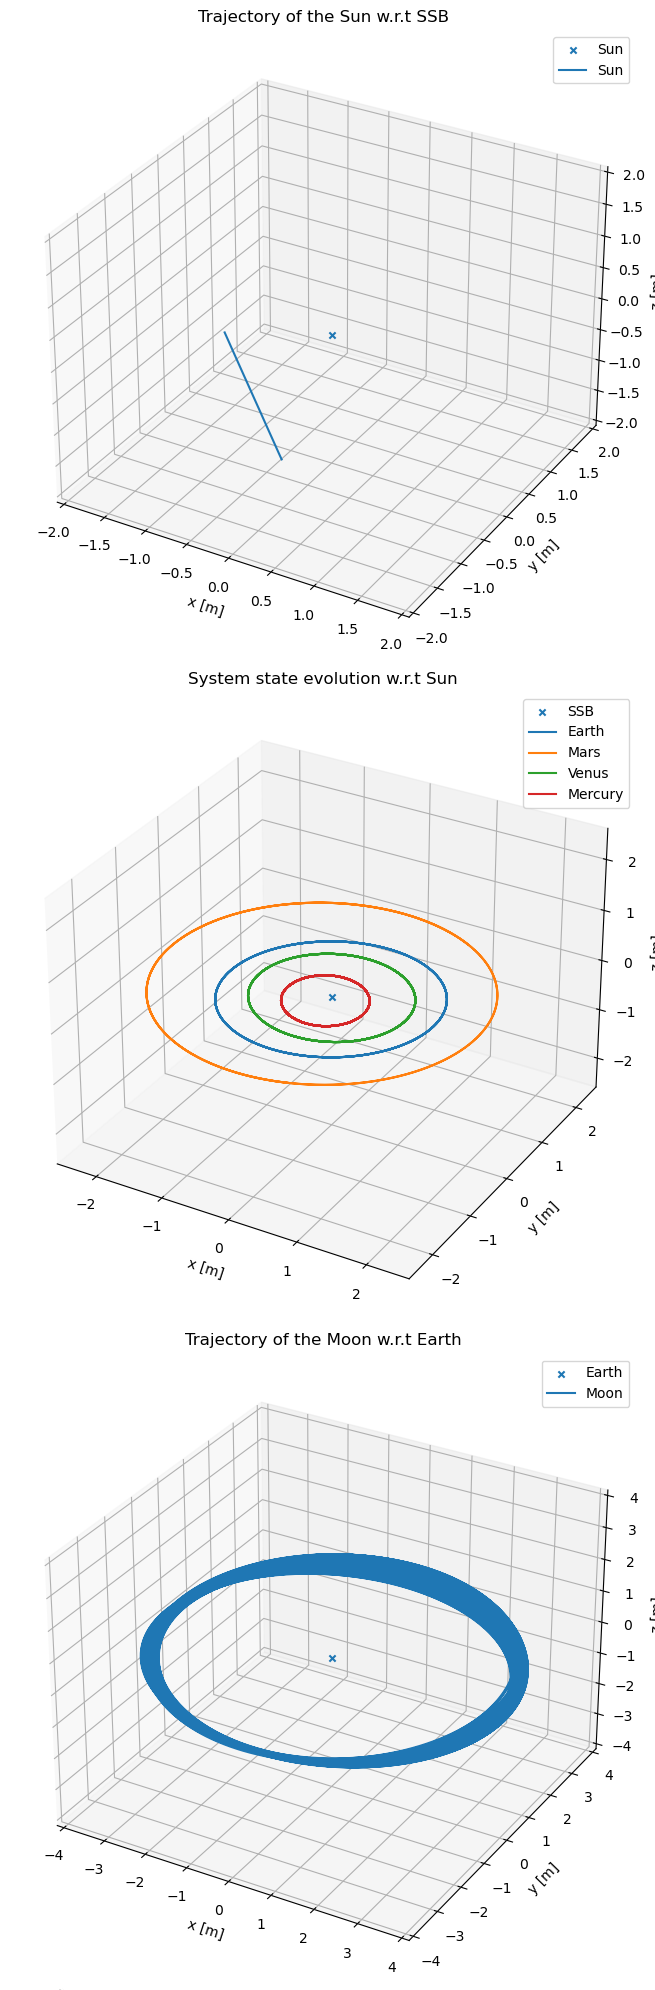

In [10]:
# Do exactly the same as for the barycentric system,
# but separate the plots according to which central body each body orbits
hierarchical_system_state_array = result2array(results_hierarchical)

fig1 = plt.figure(figsize=(8, 20))
ax1 = fig1.add_subplot(311, projection='3d')
ax1.set_title(f'Trajectory of the Sun w.r.t SSB')
ax1.scatter(0, 0, 0, marker='x', label="Sun")

ax2 = fig1.add_subplot(312, projection='3d')
ax2.set_title(f'System state evolution w.r.t Sun')
ax2.scatter(0, 0, 0, marker='x', label="SSB")

ax3 = fig1.add_subplot(313, projection='3d')
ax3.set_title(f'Trajectory of the Moon w.r.t Earth')
ax3.scatter(0, 0, 0, marker='x', label="Earth")

for i, body in enumerate(bodies_to_propagate):

    if body == "Sun":
        ax1.plot(hierarchical_system_state_array[:, 6 * i + 1], hierarchical_system_state_array[:, 6 * i + 2],
                 hierarchical_system_state_array[:, 6 * i + 3],
                 label=body)

    elif body != "Sun" and body != "Moon":
        ax2.plot(hierarchical_system_state_array[:, 6 * i + 1], hierarchical_system_state_array[:, 6 * i + 2],
                 hierarchical_system_state_array[:, 6 * i + 3],
                 label=body)

    elif body == "Moon":
        ax3.plot(hierarchical_system_state_array[:, 6 * i + 1], hierarchical_system_state_array[:, 6 * i + 2],
                 hierarchical_system_state_array[:, 6 * i + 3],
                 label=body)

axs = [ax1, ax2, ax3]
ax_lims = [[-2.0E9, 2.0E9], [-2.5E11, 2.5E11], [-4.0E8, 4.0E8]]  # equal axis limit per subplot, [m]

for ax, ax_lim in zip(axs, ax_lims):
    ax.legend()
    ax.set_xlabel('x [m]')
    ax.set_xlim(ax_lim)
    ax.set_ylabel('y [m]')
    ax.set_ylim(ax_lim)
    ax.set_zlabel('z [m]')
    ax.set_zlim(ax_lim)
    
plt.tight_layout()